In [7]:
''' imports '''

# set auto reload imported modules
%load_ext autoreload
%autoreload 2

# general imports
#import os, shutil

# numpy for array handling
import numpy as np

# import pytorch core libs
import torch

# write audio to file
#from librosa.output import write_wav

import pickle

# audio playback widget
import IPython.display as ipd

#%matplotlib widget
%matplotlib inline
import matplotlib.pyplot as plt

# add sample-rnn libs directory to path
import sys
sys.path.append('../melodyrnn/')

# import core sample-rnn model (inc. frame-lvl rnn and sample-lvl mlp)
from model import SampleRNN
from model import Predictor
from model import Generator

# wrapper for optimiser
from optim import gradient_clipping

# training criterion
from nn import sequence_nll_loss_bits

# import audio dataset management
#from dataset import SampleRNNDataset
from dataset import MelodyDataset

#from dataset import DataLoader
from dataset import MelodyDataLoader

from utils import build_audio


In [59]:
''' init dataset '''

# directory path
dir_path = '../data/MIDI/'

# init dataset
dataset = MelodyDataset(
    dir_path, key = 'C'
)


In [60]:
print(len(dataset))

25


In [61]:
''' initialise models components '''

# model parameters
#_frame_sizes = (16, 8, 4)
_frame_sizes = (16, 4, 4)
#_frame_sizes = (4, 4, 4)
_n_rnn = 1
_dim = 1024
_learn_h0 = False
#_learn_h0 = True
#_q_levels = 256 # 8 bit depth
#_q_levels = 2**10
_q_levels = 2**7
_weight_norm = True

# initialise sample-rnn model
model = SampleRNN(
    frame_sizes = _frame_sizes,
    n_rnn = _n_rnn,
    dim = _dim,
    learn_h0 = _learn_h0,
    q_levels = _q_levels,
    weight_norm = _weight_norm
)

# intitialise predictor model
predictor = Predictor(model)

generator = Generator(model)


../melodyrnn/nn.py:62: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  init(chunk)


In [62]:
''' push to device '''

# get computing device
device = ("cuda" if torch.cuda.is_available() else "cpu")

# push models to device
model = model.to(device)
predictor = predictor.to(device)


In [63]:
''' init optimiser '''

# get model parameters
params = predictor.parameters()

# initialise optimiser
optimizer = gradient_clipping( torch.optim.Adam(params, lr = 1e-4) )
#optimizer = torch.optim.Adam(params)


In [64]:
''' init dataloader '''

def collate(samples: list):
    
    ''' pad and collate list tracks for batch '''
    
    #print(samples[0].shape)
    
    # get max length sample in batch
    s = max([ sample.shape[0] for sample in samples ])
    
    # pad each sample to max length on time axis
    samples = [ np.pad(sample, (0, s - sample.shape[0]))
               for sample in samples ]
    
    # stack mini-batch samples, adjust batch to index zero
    samples = np.stack(samples, axis = 1).transpose(1, 0)
    
    # return mini-batch as tensors
    return torch.LongTensor(samples)


_overlap_len = model.lookback
print('overlap_len ', _overlap_len)

#_seq_len = 1024
#_seq_len = 512
_seq_len = 1024

_batch_size = 32

# intitialise dataloader
train_data_loader = MelodyDataLoader(
    dataset,
    batch_size = _batch_size,
    seq_len = _seq_len,
    overlap_len = _overlap_len,
    
    num_workers = 4,
    shuffle = True,
    
    collate_fn = collate,
    drop_last = True,
)


overlap_len  256


In [75]:
''' training loop '''

# set training epochs
epochs = 1000

# perform training model over epochs, iterate over range epoch limit
for _epoch in range(epochs):

    print('epoch: ', _epoch)
    
    ## model training, given dataset compute loss and update model parameters
    
    # set model to training mode (gradients stored)
    predictor.train()
    
    # iterate over dataset
    for (_iteration, data) in enumerate(train_data_loader):

        #print('iteration: ', _iteration)
        
        # zero gradients and step optimiser
        optimizer.zero_grad()

        # unpack dataset
        batch_inputs = data[0].to(device)
        batch_target = data[-1].to(device)
        
        #print(batch_inputs.shape)
        #print(batch_target.shape)
        
        # reevaluate the function multiple times; clear the gradients, compute and return loss
        def closure():

            # pass inputs through model, return output
            batch_output = predictor(batch_inputs, reset = data[1])
            #batch_output = predictor(batch_inputs, reset = False)

            # calculate loss for inputs to outputs
            loss = sequence_nll_loss_bits(batch_output, batch_target)

            #print(loss.item())

            # calculate gradients and return loss
            loss.backward()

            return loss

        # step optimiser with closure
        optimizer.step(closure)


epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
epoch:  21
epoch:  22
epoch:  23
epoch:  24
epoch:  25
epoch:  26
epoch:  27
epoch:  28
epoch:  29
epoch:  30
epoch:  31
epoch:  32
epoch:  33
epoch:  34
epoch:  35
epoch:  36
epoch:  37
epoch:  38
epoch:  39
epoch:  40
epoch:  41
epoch:  42
epoch:  43
epoch:  44
epoch:  45
epoch:  46
epoch:  47
epoch:  48
epoch:  49
epoch:  50
epoch:  51
epoch:  52
epoch:  53
epoch:  54
epoch:  55
epoch:  56
epoch:  57
epoch:  58
epoch:  59
epoch:  60
epoch:  61
epoch:  62
epoch:  63
epoch:  64
epoch:  65
epoch:  66
epoch:  67
epoch:  68
epoch:  69
epoch:  70
epoch:  71
epoch:  72
epoch:  73
epoch:  74
epoch:  75
epoch:  76
epoch:  77
epoch:  78
epoch:  79
epoch:  80
epoch:  81
epoch:  82
epoch:  83
epoch:  84
epoch:  85
epoch:  86
epoch:  87
epoch:  88
epoch:  89
epoch:  90
epoch:  9

In [86]:
''' perform sample generation '''

_n_samples = 64
_sample_length = int(100000) # ~30s

# generate samples
samples = generator(_n_samples, _sample_length).cpu().float().numpy()


In [102]:
''' save some generated samples '''

import pickle 

with open('../data/output/midi/smpls-1644-01', 'wb') as file:
    pickle.dump(samples, file)
    

In [5]:
''' save some generated samples '''

import pickle 

with open('../data/output/midi/smpls-4816-05', 'rb') as file:
    samples = pickle.load(file)
    

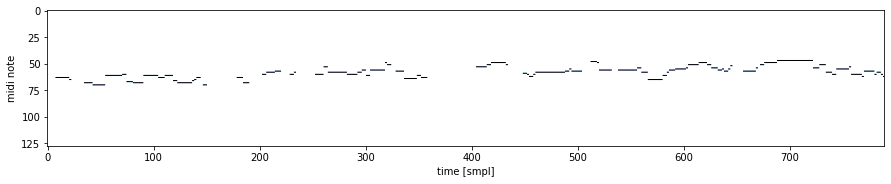

In [85]:
''' convert output to note matrix '''

i = 2

m = samples[i]
_pad = 1024
M = np.zeros((128, m.shape[0]+_pad))
for i in range(m.shape[0]):
    if m[i] != 0:
        M[int(m[i]), _pad+i] = 1

''' display melody note matrix '''
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)

# set downsample time axis [int]
ds = 128

# display track note matrix
plt.imshow(M[::-1,::ds], cmap = 'bone_r', alpha = 1.)

# format figure and display
#ax.set_ylim(35, 95)

ax.set_ylabel('midi note')
ax.set_xlabel('time [smpl]')

plt.show()


In [83]:
''' build and play audio sample '''

# set sample rate
sr = 16000

# set frame rate of midi track, adjust for playback speed
fr = 2**18 // 2

# generate audio each track
audio = build_audio(M[:, :], sr = sr, fr = fr, soft = 1e-4)

# normalise audio
audio /= audio.max()

# display playback widget
ipd.Audio(audio, rate = sr)


In [91]:
m

array([], shape=(0, 100000), dtype=float32)

In [97]:
samples[0].shape

(100000,)

In [101]:

# midi file import and parse
from mido import Message, MidiFile, MidiTrack, MetaMessage


def melody2notes(melody):
    
    # initialise note event list
    events = []

    # iterate each timestep
    for dt in range(M.shape[1])[:-1]:

        # get note index for note onset at timestep
        j = np.where(M[:, dt+1] > M[:, dt])[0]

        # note onset at timestep
        if len(j) != 0:

            # iterate each note onset
            for k in j:

                # store note index, onset time
                events.append( [k, dt] )


    # initialise note list
    notes = []

    # iterate over note events
    for note in events[:]:

        # get time from onset to note end (zero velocity)
        dt = np.where( M[note[0], note[1]+1:] == 0 )[0]

        # ensure duration exists
        if len(dt) != 0:

            # store note as list [note, onset, duration]
            notes.append([*note, dt[0]])

    return notes

# write audio to file
from librosa.output import write_wav

''' write out test midi and wav '''

l = 0

for j in range(len(samples))[:]:
    
    #m = samples[j]
    
    _2bars = 10000
    
    for k in range(samples[j].shape[0]//_2bars)[:-1]:
        
        l+=1
        
        #print(k)
        
        m = samples[j][int(k*_2bars):int((k+1)*_2bars)]
        
        #print(m.shape)

        _pad = 1024
        M = np.zeros((128, m.shape[0]+_pad))
        for i in range(m.shape[0]-1):
            if m[i] != 0:
                M[int(m[i]), _pad+i] = 1

        # get notes from Matrix
        notes = melody2notes(M)

        # init midi file, track
        mid = MidiFile()

        track = MidiTrack()
        mid.tracks.append(track)


        # set end track time
        track.append(MetaMessage('end_of_track', time = notes[-1][1] + notes[-1][2]))

        #<meta message time_signature numerator=4 denominator=4 clocks_per_click=24 notated_32nd_notes_per_beat=8 time=0>
        track.append(MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0))

        track = MidiTrack()
        mid.tracks.append(track)

        # store midi meta
        track.append(Message('program_change', program=12, time=0))


        # init time, delta
        time = 0
        delta = 0

        # iterate notes
        for note in notes:

            mod = 8

            # unpack note data
            note_number = note[0]
            start = note[1] // mod
            duration = note[2] // mod

            # get time delta, update current time
            if start > time:
                delta = start - time
                time += delta
            else:
                delta = 0

            # insert note start
            track.append(Message('note_on', note = note_number, velocity = 64, time = delta))

            # assume no note overlap
            delta += duration

            # insert note end
            track.append(Message('note_off', note = note_number, velocity = 0, time = delta))


        mid.save('../data/output/midi/sample-out-{}.midi'.format(l))
    
    
    #sr = 16000
    #fr = 2**18 // 2
    #audio = build_audio(M[:, :], sr = sr, fr = fr, soft = 1e-4)
    #audio /= audio.max()
    #write_wav('../data/output/midi/test-out-{}.wav'.format(j), audio, sr = sr)
    



In [29]:
len(samples)

128

In [44]:

mel = samples[0]

j = np.where(mel == 0)[0]

split = [ (i, j[i]) for i in range(len(j)-1) if j[i+1] > j[i]+1 ]
split


[(7167, 11264), (8191, 29696), (8703, 48640), (13311, 54784), (14335, 65024)]

In [38]:
j

(array([ 4097,  4098,  4099, ..., 96254, 96255, 96256]),)

In [34]:
''' save checkpoint '''

torch.save(model.state_dict(), '../data/melody-state-16-4-4-02')


In [79]:
''' load checkpoint '''

#_state_dict = torch.load('../data/chkpt')
_state_dict = torch.load('../data/melody-state-16-4-4-02')

model.load_state_dict(_state_dict)


<All keys matched successfully>

In [58]:
len([ dataset.file_names[i] for i in range(len(dataset)) if "key='C'" in str(dataset.midi_files[i].tracks[0][2]) ])

25

In [57]:
[ str(dataset.midi_files[i].tracks[0][2]) for i in range(len(dataset)) ]

["<meta message key_signature key='C' time=0>",
 "<meta message key_signature key='Bbm' time=0>",
 "<meta message key_signature key='Gm' time=0>",
 "<meta message key_signature key='C' time=0>",
 "<meta message key_signature key='G' time=0>",
 "<meta message key_signature key='Fm' time=0>",
 "<meta message key_signature key='Abm' time=0>",
 "<meta message key_signature key='D' time=0>",
 "<meta message key_signature key='Ebm' time=0>",
 "<meta message key_signature key='C#m' time=0>",
 "<meta message key_signature key='C' time=0>",
 "<meta message key_signature key='Abm' time=0>",
 "<meta message key_signature key='Eb' time=0>",
 "<meta message key_signature key='Ab' time=0>",
 "<meta message key_signature key='Em' time=0>",
 "<meta message key_signature key='C#m' time=0>",
 "<meta message key_signature key='Ab' time=0>",
 "<meta message key_signature key='Dm' time=0>",
 "<meta message key_signature key='Gm' time=0>",
 "<meta message key_signature key='Abm' time=0>",
 "<meta message ke